### Project: GA4-Python-Automation

In this project, my objective is to demonstrate automated generation of analytics reports using data from GA4. While GA4 generate basic reports, we aim to generate reports more advanced than default Google Analytics 4 reports by leveraging generative AI. To achieve this objective, we perform below tasks.

### Tasks planned
1. Connect and retrieve the data from Google Analytics 4 (GA4) using Google Analytics data API and perform visualisation using widely used python libraries.
2. Connect to GPT 3.5 using OpenAI API, and generate insights on data tables.
3. Generate PDF reports.
4. Connect to PowerBI using python libraries.
5. Use Github Co-pilot
6. So far, below are the tasks completed.

### Tasks completed
1. Successfully connected to GA4 and retrieve data.
2. Successully connected to GPT3.5 and generated analysis of tabular data.

#### Import required libraries

1. Import standard python libraries numpy and pandas, along viz libraries of matplotlib and seaborn. 
2. Plotly will be used at a later stage, for interactive visuals.
3. To work with date objects, import the libraries of data and timedelta from python's datetime module.
4. To interact with the Google Analytics Data API using Python, import the libraries provided by Google Analytics

In [76]:
# Data and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Date and Time libraries
from datetime import date
from datetime import timedelta
from datetime import datetime
import calendar


# Google Analytics Modules and Libraries
import os
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

# OpenAI API
from openai import OpenAI

# Display text in markdown 
from IPython.display import display, Markdown

# warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Word Document
from docx import Document



#### Specify a data source 
To start working with Google Analytics Data APIv1 (Beta), first [specify a data source](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#specify_a_data_source)

In [77]:
#  Point the GOOGLE_APPLICATION_CREDENTIALS environment variable to the file where credentials are located. 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r'ga4python3-8fc10d9b3712.json'
property_id = '382343330' 

# Set up a an instance of BetaAnalyticsDataClient
client = BetaAnalyticsDataClient()

- The json file containing credentials is located in the current directory.
- r before a string denotes a raw string literal. All Backslashes are treated as literal backslashes. Useful when accessing directories with backslashes.

#### Generate a report

[To generate a report](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#generate_a_report), construct a RunReportRequest object and start with the following input request parameters:

- A valid entry in the dateRanges field.
- At least one valid entry in the dimensions field.
- At least one valid entry in the metrics field.
- (optional) specify the order in which you want the data to be displayed.

In [78]:

# Specify the date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Specify the dimensions
dimensions = [
    Dimension(name='month'),
    ]

# Specify the metrics
metrics = [
        Metric(name="activeUsers"),
        Metric(name="newUsers"),
        Metric(name="sessions"),
        Metric(name="engagedSessions"),
        Metric(name="bounceRate"),            
         ]

# Specify the order in which you want the data to be returned. Sort by dimension or metric.
order_bys = [
    OrderBy(OrderBy(dimension = {'dimension_name': 'month'}, desc=False)),
    ]

In [79]:
# Create the request object with the requests parameters
request = RunReportRequest(
    property=f'properties/{property_id}',
    dimensions=dimensions,
    metrics=metrics,
    date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    order_bys=order_bys
)

# Send the request to the API   
response = client.run_report(request)


#### Explore the contents of API response object

In [80]:
print("The API response rowcount:", response.row_count)
print()

# Print dimension headers
print("The API response dimension headers:")
for header in response.dimension_headers:
    print(" ", header.name)
print()

# Print metric headers
print("The API response metric headers:")
for header in response.metric_headers:
    print(" ", header.name)
print()

# Print data rows
#print("The API response data rows:")
for row in response.rows:
    dimensions = [dim.value for dim in row.dimension_values]
    metrics = [metric.value for metric in row.metric_values]
    #print(" Dimensions:", dimensions, "Metrics:", metrics)

The API response rowcount: 7

The API response dimension headers:
  month

The API response metric headers:
  activeUsers
  newUsers
  sessions
  engagedSessions
  bounceRate



#### Define functions
1. Process the API response 
2. Create a data frame

In [81]:
# Define a function to process the API response
def process_response(response):
    '''Process the API response to extract the data and return a list of dictionaries.'''


    # Extract count of dimensions and metrics
    dim_len = len(response.dimension_headers)
    metric_len = len(response.metric_headers)

    # List to store row data
    all_data = []

    # Process each row in the response
    for row in response.rows:
        row_data = {}  # Dictionary to store current row's data
        
        # Extract dimension values
        for i in range(dim_len):
            dim_name = response.dimension_headers[i].name  # Dimension name
            dim_value = row.dimension_values[i].value  # Dimension value
            row_data[dim_name] = dim_value
        
        # Extract metric values
        for i in range(metric_len):
            metric_name = response.metric_headers[i].name  # Metric name
            metric_value = row.metric_values[i].value  # Metric value
            row_data[metric_name] = metric_value
        
        # Add the row's data to the list
        all_data.append(row_data)

    return all_data


# Define a function to create a DataFrame from the processed API response data
def create_dataframe(all_data):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)
    return df



In [82]:
#### Create a Word Document for the Report

# Create a new Document
document = Document()

# Add a heading
document.add_heading('Google Analytics Report', level=1)

# Add more content as needed
# For example, add a paragraph
document.add_paragraph('This is an example paragraph in the document.')

# Define a function to add a DataFrame to the Word document
def add_dataframe_to_document(document, df, title):
    """
    Adds a pandas DataFrame to a Word document as a table.
    
    Args:
    - document: A Document object from python-docx.
    - df: The pandas DataFrame to add.
    - title: The title for the table.
    """
    document.add_heading(title, level=1)
    
    # Adding a table with an extra row for headers
    table = document.add_table(rows=(df.shape[0] + 1), cols=df.shape[1])
    table.style = 'Table Grid'
    
    # Adding header row
    for col_index, col_name in enumerate(df.columns):
        table.cell(0, col_index).text = col_name
    
    # Adding data rows
    for row_index, row in df.iterrows():
        for col_index, item in enumerate(row):
            table.cell(row_index + 1, col_index).text = str(item)



            

#### Convert the data from response object to Dataframe

In [83]:
all_data = process_response(response)
df = create_dataframe(all_data)
df.head()

,month,activeUsers,newUsers,sessions,engagedSessions,bounceRate
0,06,851,848,1166,779,0.33190394511149229
1,07,1093,1066,1467,913,0.3776414451261077
2,08,1155,1120,1545,957,0.38058252427184464
3,09,1166,1141,1547,936,0.3949579831932773
4,10,1083,1055,1393,857,0.38478104809763103


#### Check for datatypes in the dataframe

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   month            7 non-null      object
 1   activeUsers      7 non-null      object
 2   newUsers         7 non-null      object
 3   sessions         7 non-null      object
 4   engagedSessions  7 non-null      object
 5   bounceRate       7 non-null      object
dtypes: object(6)
memory usage: 464.0+ bytes


We see that all columns are of data type object and can be converted to suitable data

#### Change the datatypes suitably

In [85]:
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[int(x)])
df[['activeUsers', 'newUsers', 'sessions', 'engagedSessions']] = df[['activeUsers', 'newUsers', 'sessions', 'engagedSessions']].astype(int)
df['bounceRate'] = df['bounceRate'].astype(float).round(2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            7 non-null      object 
 1   activeUsers      7 non-null      int32  
 2   newUsers         7 non-null      int32  
 3   sessions         7 non-null      int32  
 4   engagedSessions  7 non-null      int32  
 5   bounceRate       7 non-null      float64
dtypes: float64(1), int32(4), object(1)
memory usage: 352.0+ bytes


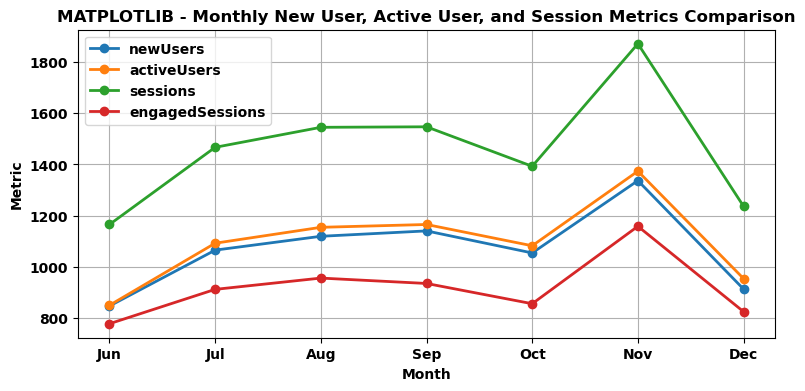

In [86]:
# Use Matplotlib to plot line graph of various metrics spread over specified period

plt.figure(figsize=(9, 4))

metrics = ['newUsers', 'activeUsers', 'sessions', 'engagedSessions'] 

# plt.plots generate matplotlib line graphs. Specify x and y axes. 
plt.plot(df['month'], df[metrics], label=metrics, marker = 'o', linewidth = 2)
plt.xlabel('Month')
plt.ylabel('Metric')
plt.title('MATPLOTLIB - Monthly New User, Active User, and Session Metrics Comparison')
plt.legend()
plt.grid(True)
plt.savefig('Matplotlib_metrics_comparison.png', bbox_inches='tight')
document.add_paragraph('MATPLOTLIB - Metrics Comparison')
document.add_picture('Matplotlib_metrics_comparison.png', width=document.sections[0].page_width * 0.8)
plt.show()



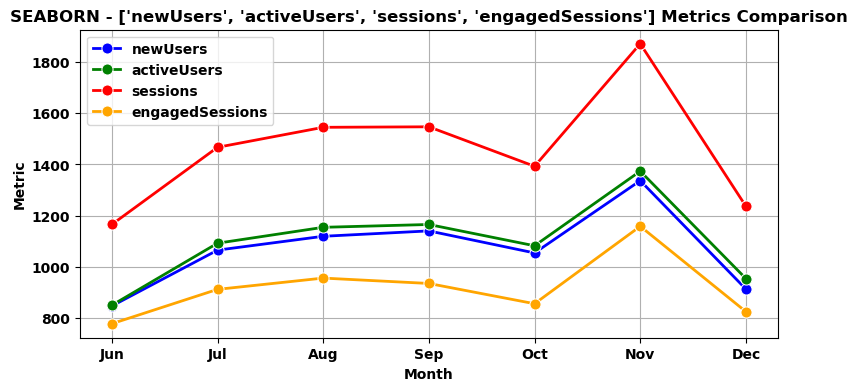

In [87]:
# Use Seaborn library to represent the same line graph as above
# Specify color choice for each metric
colors = {'newUsers': 'blue', 'activeUsers': 'green', 'sessions': 'red', 'engagedSessions': 'orange'}

plt.figure(figsize=(9, 4))
for metric in metrics: 
    sns.lineplot(data=df, x='month', y=metric, label=metric, marker = 'o', color = colors[metric], linewidth = 2, markersize = 8)
    
plt.xlabel('Month')
plt.ylabel('Metric')
plt.title(f'SEABORN - {metrics} Metrics Comparison')
plt.grid(True)
plt.savefig('SEABORN_Metrics_Comparison.png', bbox_inches='tight')
document.add_paragraph('SEABORN - Metrics Comparison')
document.add_picture('Seaborn_metrics_comparison.png', width=document.sections[0].page_width * 0.8)
plt.show()

### Monthly New User, Active User, and Session Metrics Comparison

In [88]:
# Load data in df to excel

df.to_excel("Monthly_basic_metrics.xlsx",sheet_name = 'Basic_performance_metrics', engine = 'xlsxwriter')

# Add the DataFrame to the Word document
add_dataframe_to_document(document, df, 'Monthly Basic Metrics')

- New users: The number of users who interacted with your site or launched your app for the first time (event triggered: first_open or first_visit). 

- Active users: The number of distinct users who visited your site or app.

- Sessions: The number of sessions that began on your site or app (event triggered: session_start).

### Top 5 Landing Pages by Active Users

**Specify the input request parameters**

In [89]:
# Specify the date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Specify the dimensions
dimensions = [
    Dimension(name='landingPage'),
    ]

# Specify the metrics
metrics = [
        Metric(name="activeUsers"),
        Metric(name="bounceRate"),            
         ]

# Specify the order in which you want the data to be returned. Sort by dimension or metric.
order_bys = [
    OrderBy(OrderBy(metric = {'metric_name': 'activeUsers'}, desc=True)),
    ]

In [90]:
# Create the request object with the requests parameters
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=dimensions,
        metrics=metrics,
        order_bys = order_bys,
        date_ranges=[DateRange(start_date=start_date, end_date=end_date,)],
        )

# Send the request to the API and store the response
response = client.run_report(request)

# Process the response and create a DataFram
all_data = process_response(response)
df = create_dataframe(all_data)

# Display the first few rows of the DataFrame
df.head()

# add the DataFrame to the Word document
add_dataframe_to_document(document, df.head(5), 'Top Landing Pages by Active Users')

#### While you can see bounce rate in UA, this feature has been removed in GA4. You have to create a report in GA4 to see it.

- Landing page: The page path associated with the first pageview in a session.

- Bounce rate: The percentage of sessions that were not engaged ((Sessions Minus Engaged sessions) divided by Sessions). This metric is returned as a fraction; for example, 0.2761 means 27.61% of sessions were bounces.

### Events Comparison

In [91]:
# Create the request object with the requests parameters
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="eventName")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

response = client.run_report(request)

# Process the response and create a DataFrame
all_data = process_response(response)
df = create_dataframe(all_data)


# Transform the data type of the 'activeUsers' column to integer
df['activeUsers'] = df['activeUsers'].astype(int)


# Display the first few rows of the DataFrame
df.head()

,eventName,activeUsers
0,page_view,7518
1,session_start,7513
2,first_visit,7511
3,user_engagement,5496
4,thank_you,307


In [92]:
# Add the DataFrame to the Word document
add_dataframe_to_document(document, df.head(), 'Events Comparison')

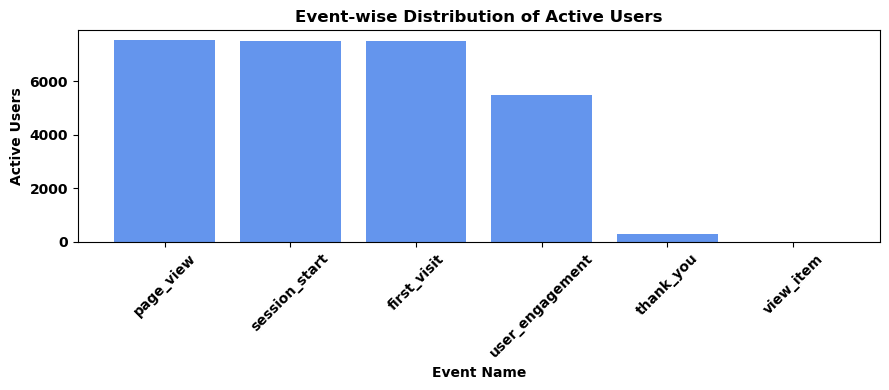

In [93]:
plt.figure(figsize=(9, 4))
plt.bar(df['eventName'], df['activeUsers'], color = 'cornflowerblue')
#sns.barplot(data=df, x='eventName', y='activeUsers', color = 'skyblue') 
plt.xlabel('Event Name')
plt.ylabel('Active Users')      
plt.title('Event-wise Distribution of Active Users')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('Event-wise-Comp.png', bbox_inches='tight')
document.add_paragraph('Event-wise Distribution of Active Users')
document.add_picture('Event-wise-Comp.png', width=document.sections[0].page_width * 0.8)
plt.show()  # Display the plot


1. We observe that page_view, session_start, first_visit have similar event distribution.
2. User engagement is 75% of above 3 pages.
3. Thank you page shows low count.

In [94]:
# Run report
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

response = client.run_report(request)

# Process the response and create a DataFrame
all_data = process_response(response)
df = create_dataframe(all_data)

# Transform the data types of the 'activeUsers' and 'averageSessionDuration' columns to integer and float respectively
# Sort the DataFrame by 'averageSessionDuration' in descending order
df['averageSessionDuration'] = df['averageSessionDuration'].astype(float).round(0)
df['averageSessionDuration'] = df['averageSessionDuration'].astype(int)
df['activeUsers'] = df['activeUsers'].astype(int)
df = df.sort_values(by='averageSessionDuration', ascending= False)
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[int(x)])
df = df.reset_index(drop=True)

# Display the first few rows of the DataFrame
display(df.head(5))

# Display the datatypes of the columns
df.info()

# Shape of the DataFrame
df.shape

,month,sessionMedium,averageSessionDuration,activeUsers
0,Jul,email,299,6
1,Oct,referral,283,33
2,Jun,organic,196,646
3,Nov,(not set),196,6
4,Nov,organic,192,934


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   month                   41 non-null     object
 1   sessionMedium           41 non-null     object
 2   averageSessionDuration  41 non-null     int32 
 3   activeUsers             41 non-null     int32 
dtypes: int32(2), object(2)
memory usage: 1.1+ KB


(41, 4)

In [95]:
# Create a pivot table with 'month' as the index, 'sessionMedium' as the columns, and 'averageSessionDuration' as the values
pivot_df = df.pivot(index='month', columns='sessionMedium', values='averageSessionDuration')
pivot_df = pivot_df.fillna(0) # Fill NaN values with 0
        
# Display the first few rows of the pivot table
pivot_df.head(10)

# Add the DataFrame to the Word document
add_dataframe_to_document(document, df.head(7), 'Monthly Average Session Duration')


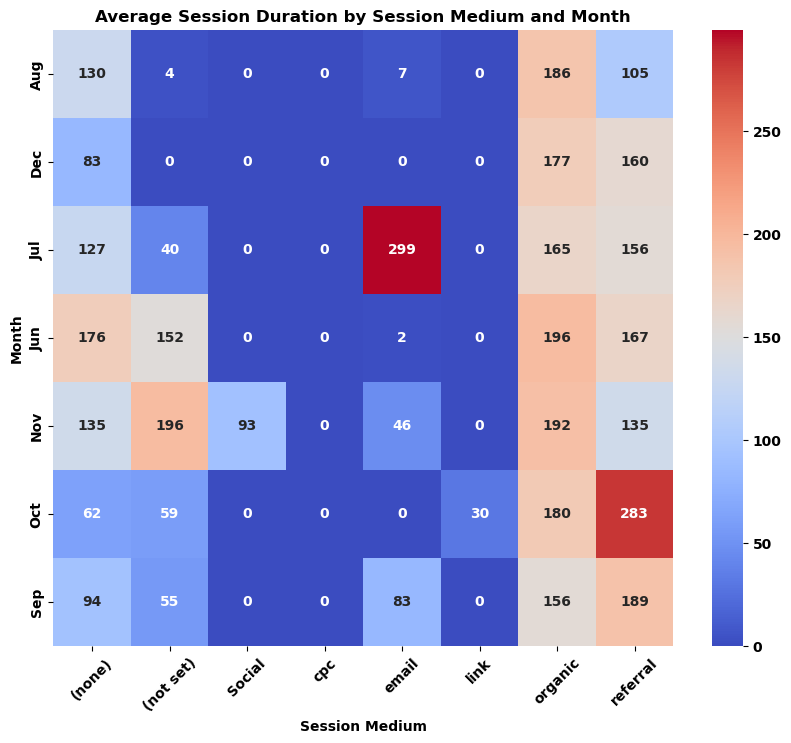

In [96]:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm' , fmt=".0f")
plt.title('Average Session Duration by Session Medium and Month')
plt.ylabel('Month')
plt.xlabel('Session Medium')
plt.xticks(rotation=45)
plt.savefig('Heatmap.png', bbox_inches='tight')
document.add_paragraph('Heatmap of Average Session Duration by Session Medium and Month')
document.add_picture('Heatmap.png', width=document.sections[0].page_width * 0.8)
plt.show()


In [97]:
# Convert the dataframe to a string
table_str = pivot_df.to_string(index=False)


prompt = f"""
Analyze the following dataset representing the Average Session Duration by Session Medium and Month:

{table_str}

Provide insights on data trends and patterns.:

"""

client_openai = OpenAI()

completion = client_openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a data analyst."},
    {"role": "user", "content": prompt}
  ]
)



# Correctly accessing the 'content' attribute of the 'ChatCompletionMessage' object
message_string = completion.choices[0].message.content  # Access the 'content' attribute for the string

display(Markdown(message_string))

# Add the insights to the Word document
document.add_heading('Insights on Data Trends and Patterns', level=1)
document.add_paragraph(message_string)

To analyze the Average Session Duration by Session Medium and Month, we can first calculate the average duration for each medium across the months. Here are the average session durations for each medium:

- (none): 111.71
- (not set): 63.14
- Social: 13.29
- cpc: 0.00
- email: 59.71
- link: 4.29
- organic: 183.29
- referral: 178.00

Next, we can identify some insights and trends from the data:

1. Organic and referral sessions have the highest average session durations at 183.29 and 178.00 respectively.
2. Email and (none) sessions also show relatively high average durations compared to other mediums.
3. CPC, Social, and Link sessions have very low average durations, with some mediums even having zeroes indicating no recorded duration.
4. Across different months, there is variability in average session durations for each medium, indicating potential seasonality or changes in user behavior over time.

In summary, the data shows variations in average session durations across different mediums, with organic and referral sessions generally having longer durations compared to other mediums. It would be useful to further investigate the reasons behind these trends and patterns, potentially leading to strategic decisions for optimizing session durations and engagement on different platforms.

In the above categories, we observe that average session duration is highest for email in July and referrals in October month

c:\Users\botch_yp7a42y\anaconda3\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\botch_yp7a42y\anaconda3\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 1500x1500 with 0 Axes>

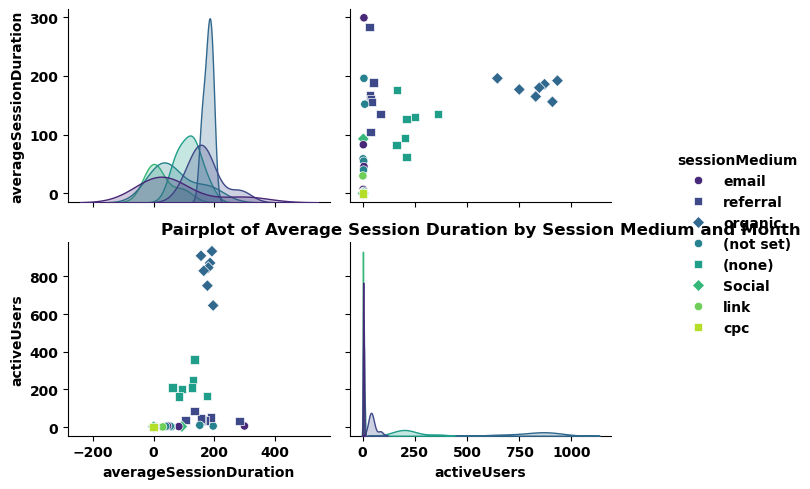

In [98]:
plt.figure(figsize=(15, 15))
sns.pairplot(df, hue='sessionMedium', palette='viridis', diag_kind='kde', markers=["o", "s", "D"]) 

plt.title('Pairplot of Average Session Duration by Session Medium and Month')
plt.tight_layout()
plt.savefig('pairplot.png', bbox_inches='tight')
document.add_paragraph('Pairplot of Average Session Duration by Session Medium and Month')
document.add_picture('pairplot.png', width=document.sections[0].page_width * 0.8)
plt.show()

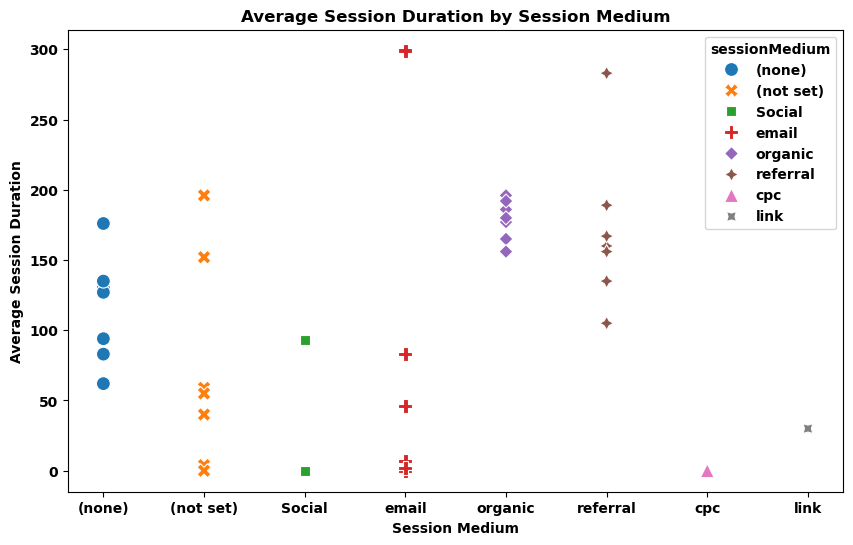

In [99]:
grouped_df = df.groupby(['month', 'sessionMedium']).agg(averageSessionDuration_mean=('averageSessionDuration', 'mean')).reset_index()

grouped_df.head()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_df, x='sessionMedium', y='averageSessionDuration_mean', hue='sessionMedium', style='sessionMedium', s=100)
plt.title('Average Session Duration by Session Medium')
plt.xlabel('Session Medium')
plt.ylabel('Average Session Duration')
plt.savefig('AverageSession_Duration_by_medium.png', bbox_inches='tight')
document.add_paragraph(' Average Session Duration by Session Medium')
document.add_picture('AverageSession_Duration_by_medium.png', width=document.sections[0].page_width * 0.8)
plt.show()


In [100]:
# Convert the dataframe to a string
table_str = grouped_df.to_string(index=False)


prompt = f"""
Analyze the following dataset representing the Average Session Duration by Session Medium:

{table_str}

Provide insights on data trends and patterns.:

"""

client_openai = OpenAI()

completion = client_openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a data analyst."},
    {"role": "user", "content": prompt}
  ]
)



# Correctly accessing the 'content' attribute of the 'ChatCompletionMessage' object
message_string = completion.choices[0].message.content  # Access the 'content' attribute for the string

display(Markdown(message_string))

Based on the Average Session Duration by Session Medium dataset, we can observe the following trends and patterns:

1. In August, December, July, June, November, October, and September, there are different session mediums recorded with respective average session durations.
2. The session mediums include (none), (not set), Social, email, organic, referral, cpc, and link.
3. The (none) session medium appears consistently in each month, and the average session durations vary across the months.
4. The (not set) session medium also appears in several months, and it generally has lower average session durations compared to other mediums.
5. Social and email session mediums show a significant variation in average session durations across the months.
6. Organic and referral session mediums tend to have higher average session durations compared to other mediums in most months.
7. There are some session mediums that only appear in specific months, such as cpc in July and link in October, with varying average session durations.
8. There may be seasonal patterns in the data as we see fluctuations in average session durations across the months.

To further analyze the data trends and patterns, additional statistical analysis, visualization, and trend analysis over time could be conducted to provide more insights into the behavior of users across different session mediums.

### Device model, Age and, Gender 

In [101]:
# Report request

mobileDeviceModel_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="mobileDeviceModel")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

response = client.run_report(mobileDeviceModel_request)

# Process the response and create a DataFrame
all_data = process_response(response)
df = create_dataframe(all_data)

# Transform the data type of the 'activeUsers' column to integer
df['activeUsers'] = df['activeUsers'].astype(int)

# Display the first few rows of the DataFrame
df.head()

# Add the DataFrame to the Word document
add_dataframe_to_document(document, df.head(), 'Mobile Device Model Data')

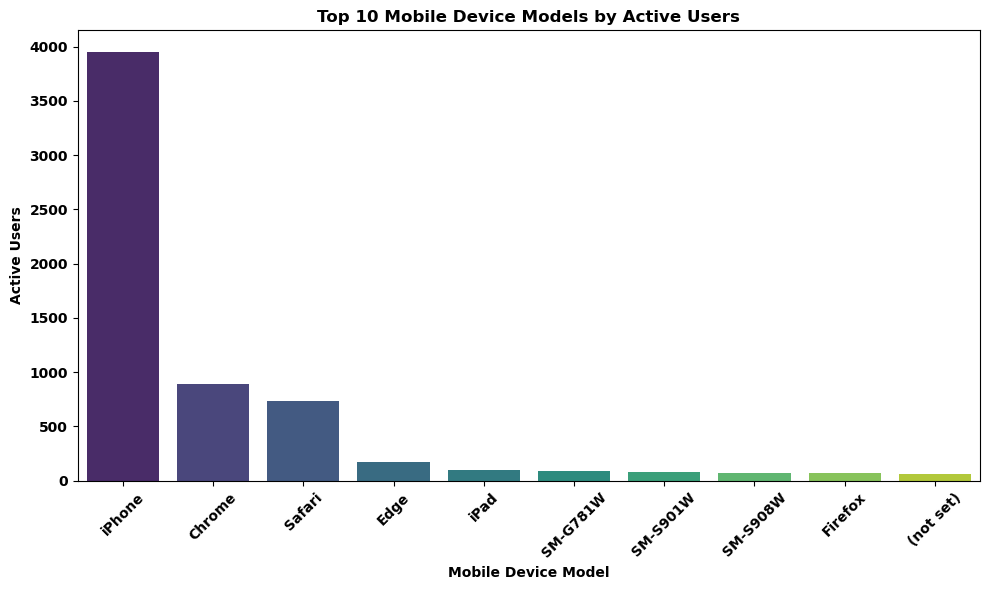

In [102]:
# Visualization

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df.head(10), x='mobileDeviceModel', y='activeUsers', palette='viridis')
plt.xlabel('Mobile Device Model')
plt.ylabel('Active Users')
plt.title('Top 10 Mobile Device Models by Active Users')
plt.xticks(rotation=45) 
plt.savefig('Mobile_Device_Models.png', bbox_inches='tight')
document.add_paragraph('Top 10 Mobile Device Models by Active Users')
document.add_picture('Mobile_Device_Models.png', width=document.sections[0].page_width * 0.8)

plt.tight_layout()

plt.show()

In [103]:

# Convert the dataframe to a string
table_str = df.to_string(index=False)

# Create the prompt
prompt = f"""
Analyze the following dataset representing the number of active users for different mobile device models:

{table_str}

Provide insights on:
1. The dominance of mobile device models in terms of active users.
2. The significance of web browsers in the context of active users.
3. Suggestions for areas of further analysis.
"""

#print(prompt)  # This is the prompt you can use with OpenAI's API


In [104]:

client_openai = OpenAI()

completion = client_openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a data analyst."},
    {"role": "user", "content": prompt}
  ]
)



ChatCompletionMessage(content="Sure, let's analyze the dataset to provide insights on the dominance of mobile device models and the significance of web browsers in terms of active users.\n\n1. 

Dominance of Mobile Device Models:\n- 

The dataset shows that the iPhone has the highest number of active users with 3953 users, making it the most dominant mobile device model in terms of active users.\n- 

Following iPhone, Chrome and Safari have 888 and 729 active users respectively, indicating a lower but still significant user base.\n- The Edge browser and iPad have the lowest number of active users with 172 and 95 users respectively.\n\n2. 

Significance of Web Browsers:\n- Among the mobile device models listed, Chrome is the only web browser included in the dataset and has the second-highest number of active users with 888 users.\n- This suggests that web browsers, especially popular ones like Chrome, have a significant impact on the active user base, even when compared to specific mobile devices like iPhone and Safari.\n\n3. 

Suggestions for Further Analysis:\n- Explore the usage patterns and behaviors of users based on the type of mobile device model they use. This could help identify preferences and trends that influence active user numbers.\n- Analyze the demographics of users using different mobile device models and web browsers to understand if there are specific target groups for each device/browser.\n- 

Investigate the impact of mobile device model and web browser compatibility on user engagement and retention.\n- 

Track changes in active user numbers over time to identify any trends or fluctuations that could be related to software updates, marketing campaigns, or external factors.\n\n

By conducting further analysis based on these suggestions, you can gain a deeper understanding of the relationships between mobile device models, web browsers, and active user numbers, and potentially uncover insights to optimize user experiences and marketing strategies.", role='assistant', function_call=None, tool_calls=None)

`print(completion.choices[0].message)`

In [105]:
from IPython.display import display, Markdown

# Correctly accessing the 'content' attribute of the 'ChatCompletionMessage' object
message_string = completion.choices[0].message.content  # Access the 'content' attribute for the string

display(Markdown(message_string))



### 1. Dominate Mobile Device Models in Terms of Active Users:
- The top 5 mobile device models in terms of active users are:
   1. iPhone: 3953 active users
   2. Chrome: 888 active users
   3. Safari: 729 active users
   4. Edge: 172 active users
   5. iPad: 95 active users
   
- As we can see, iPhone is the most dominant mobile device model among the active users, followed by Chrome and Safari.

### 2. Significance of Web Browsers in the Context of Active Users:
- Web browsers like Chrome, Safari, and Firefox have significant active user bases, which indicates a diverse user preference for browsing on mobile devices.
- Chrome with 888 active users and Safari with 729 active users are among the top 3 in terms of active users, suggesting their popularity.

### 3. Suggestions for Areas of Further Analysis:
- Analyze the trends in active users for different mobile device models over time to identify potential growth or decline patterns.
- Explore the user demographics associated with each mobile device model to understand the target audience better.
- Investigate the correlation between mobile device models and user engagement metrics to optimize user experience.
- Compare active users by mobile device models across different regions to identify regional preferences.
- Conduct a deep dive analysis into user behavior based on the web browser used to access the platform, providing insights for browser compatibility and optimization.

By further exploring these areas, you can gain a more comprehensive understanding of user preferences, behavior, and trends within the dataset.

In [106]:
# Add the DataFrame to the Word document
document.add_paragraph(message_string)

In [107]:
# Save the document to a file
document.save('Google_Analytics_Report.docx')